# 07 Algal bloom detection in MERIS FRS products with SNAP

## <a name="quicklink">Quick link

* [Objective](#objective)
* [Data](#data)
* [Workflow](#workflow)
* [License](#license)

## <a name="objective">Objective 

The objective of this module is to detect algal blooms using Envisat MERIS FRS data and the SNAP toolbox.

## <a name="data">Data

Envisat was ESA's successor to ERS. Envisat was launched in 2002 with 10 instruments aboard and at eight tons is the largest civilian Earth observation mission.

MERIS was a programmable, medium-spectral resolution, imaging spectrometer operating in the solar reflective spectral range. Fifteen spectral bands can be selected by ground command.

The instrument scanned the Earth's surface by the so called "push-broom" method. Linear CCD arrays provided spatial sampling in the across-track direction, while the satellite's motion provides scanning in the along-track direction.
MERIS was designed so that it could acquire data over the Earth whenever illumination conditions were suitable. 

The instrument's 68.5° field of view around nadir covered a swath width of 1150 km. This wide field of view was shared between five identical optical modules arranged in a fan shape configuration.

The Envisat mission ended on 08 April 2012, following the unexpected loss of contact with the satellite.

### <a name="workflow">Workflow

* Step 1: Define the Envisat MERIS FRS product to access

In [1]:
import snappy
from snappy import jpy
from snappy import GPF
from snappy import HashMap
from snappy import ProductIO
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
meris_prd = "MER_FRS_1PPEPA20080917_160513_000005122072_00126_34248_4962.N1"

* Step 2: Access the product metadata

In [3]:
product = ProductIO.readProduct("data/" + meris_prd)

width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
description = product.getDescription()
band_names = product.getBandNames()

In [4]:
print("Bands:   %s" % (list(band_names)))

Bands:   ['radiance_1', 'radiance_2', 'radiance_3', 'radiance_4', 'radiance_5', 'radiance_6', 'radiance_7', 'radiance_8', 'radiance_9', 'radiance_10', 'radiance_11', 'radiance_12', 'radiance_13', 'radiance_14', 'radiance_15', 'l1_flags', 'detector_index']


* Step 3: Subset the product geografically 

In [5]:
HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')
 
lon_min = -84.18
lat_min = 41.5
lon_max = -78.5
lat_max = 43.61
  
pt1 = "%s %s" % (lon_min, lat_min)
pt2 = "%s %s" % (lon_max, lat_min)
pt3 = "%s %s" % (lon_max, lat_max)
pt4 = "%s %s" % (lon_min, lat_max)  
    
wkt = "POLYGON((%s, %s, %s, %s, %s))" % (pt1, pt2, pt3, pt4, pt1)
 
geom = WKTReader().read(wkt)
 
parameters = HashMap()
parameters.put('geoRegion', geom)
parameters.put('outputImageScaleInDb', False)
parameters.put('copyMetadata', True)
subset = GPF.createProduct('Subset', parameters, product)

* Step 4: Plot the RGB image of the substetted product

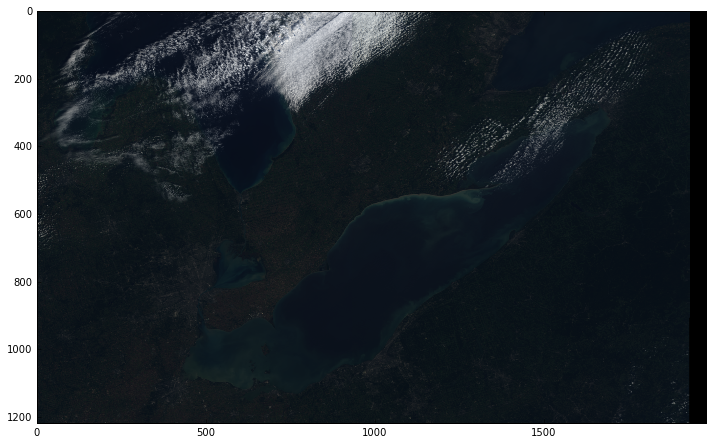

In [6]:
b7 = subset.getBand('radiance_7')
b5 = subset.getBand('radiance_5')
b3 = subset.getBand('radiance_3')
b2 = subset.getBand('radiance_2')

w = b7.getRasterWidth()
h = b7.getRasterHeight()

b7_data = np.zeros(w * h, np.float32)
b7.readPixels(0, 0, w, h, b7_data)
b7_data.shape = h, w

b5_data = np.zeros(w * h, np.float32)
b5.readPixels(0, 0, w, h, b5_data)
b5_data.shape = h, w

b3_data = np.zeros(w * h, np.float32)
b3.readPixels(0, 0, w, h, b3_data)
b3_data.shape = h, w

b2_data = np.zeros(w * h, np.float32)
b2.readPixels(0, 0, w, h, b2_data)
b2_data.shape = h, w

red = (b7_data*256/(np.amax(b7_data)-np.amin(b7_data)))
green = (b5_data*256/(np.amax(b5_data)-np.amin(b5_data)))
blue = ((b2_data*256/(np.amax(b2_data)-np.amin(b2_data))) + 
         (b3_data*256/(np.amax(b3_data)-np.amin(b3_data)))) / 2


rgb_uint8 = np.dstack((red, green, blue)).astype(np.uint8) 

width = 12
height = 12
plt.figure(figsize=(width, height))
img = Image.fromarray(rgb_uint8)
imgplot = plt.imshow(img)


* Step 5: Apply the arithmetic expression

In [7]:
expression = "l1_flags.INVALID?0:radiance_13>15?0:100+radiance_9-(radiance_8+(radiance_10-radiance_8)*27.524/72.570)"

In [8]:
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

HashMap = jpy.get_type('java.util.HashMap')
BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

In [9]:
targetBand1 = BandDescriptor()
targetBand1.name = 'band_math'
targetBand1.type = 'float32'
targetBand1.expression = expression

targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand1

parameters = HashMap()
parameters.put('targetBands', targetBands)

result = GPF.createProduct('BandMaths', parameters, subset)

Step 6: Plot the result

In [10]:
band1 = result.getBand('band_math')

w = band1.getRasterWidth()
h = band1.getRasterHeight()

band1_data = np.zeros(w * h, np.float32)
band1.readPixels(0, 0, w, h, band1_data)

product.dispose()

band1_data.shape = h, w


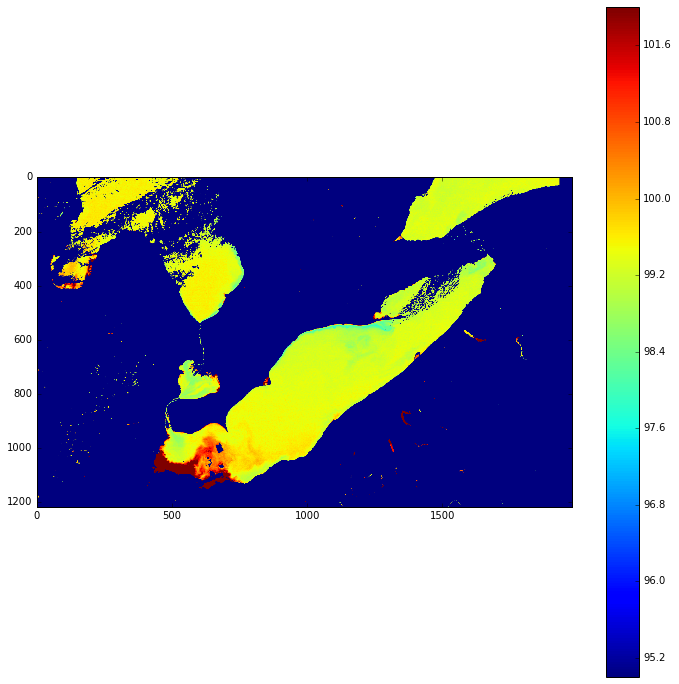

In [11]:
width = 12
height = 12
plt.figure(figsize=(width, height))
imgplot = plt.imshow(band1_data, vmin=95, vmax=102)
plt.colorbar()

* Step 7: Reproject and plot the result

In [12]:
parameters = HashMap()

parameters.put('crs', 'EPSG:4326')

reproject = GPF.createProduct('Reproject', parameters, result)

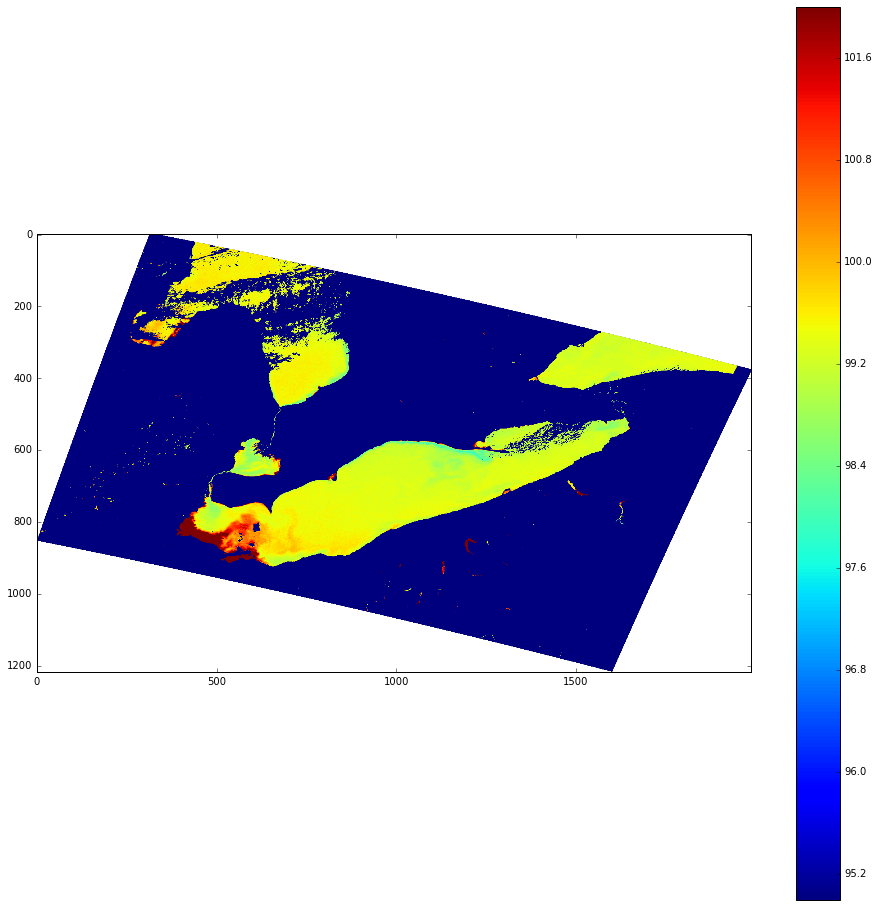

In [13]:
from mpl_toolkits.basemap import Basemap, cm

band1 = reproject.getBand('band_math')

w = band1.getRasterWidth()
h = band1.getRasterHeight()

band1_data = np.zeros(w * h, np.float32)
band1.readPixels(0, 0, w, h, band1_data)

band1_data.shape = h, w
width = 16
height = 16
plt.figure(figsize=(width, height))

imgplot = plt.imshow(band1_data, vmin=95, vmax=102)
plt.colorbar()

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.